# ResNet34

### Settings

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from helper_evaluation import set_all_seeds, set_deterministic
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples

RANDOM_SEED = 1
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Data Loading

In [4]:
# Set random seed
set_all_seeds(RANDOM_SEED)

transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((64,64)),
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # （0.5,0.5,0.5）
    ])

# Load images 
dataset_dir = './data'
dataset = torchvision.datasets.ImageFolder(root = dataset_dir, transform = transform)

# Determine sizes of the training set and the test set
total_size = len(dataset)
train_size = int(np.floor(total_size * 0.6))
test_size = int(np.floor(total_size * 0.3))
valid_size = total_size - test_size - train_size

In [5]:
# Split the entire dataset into 60% of training set, 30% of test set, and 10% validation set.
training_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, valid_size])

In [6]:
# Loaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False)

### Model

In [7]:
# Code taken & adjusted from: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(torch.nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Epoch: 001/050 | Batch 0000/0018 | Loss: 0.7283
Epoch: 001/050 | Batch 0003/0018 | Loss: 4.8739
Epoch: 001/050 | Batch 0006/0018 | Loss: 18.1242
Epoch: 001/050 | Batch 0009/0018 | Loss: 6.3516
Epoch: 001/050 | Batch 0012/0018 | Loss: 1.4599


C:\Users\Zining\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 001/050 | Batch 0015/0018 | Loss: 1.1421
Epoch: 001/050 | Train: 50.92% | Validation: 54.56%
Time elapsed: 0.78 min
Epoch: 002/050 | Batch 0000/0018 | Loss: 0.8379
Epoch: 002/050 | Batch 0003/0018 | Loss: 1.2688
Epoch: 002/050 | Batch 0006/0018 | Loss: 0.8329
Epoch: 002/050 | Batch 0009/0018 | Loss: 1.1050
Epoch: 002/050 | Batch 0012/0018 | Loss: 1.0472
Epoch: 002/050 | Batch 0015/0018 | Loss: 1.1073
Epoch: 002/050 | Train: 49.04% | Validation: 52.05%
Time elapsed: 1.22 min
Epoch: 003/050 | Batch 0000/0018 | Loss: 0.6137
Epoch: 003/050 | Batch 0003/0018 | Loss: 0.6173
Epoch: 003/050 | Batch 0006/0018 | Loss: 0.6075
Epoch: 003/050 | Batch 0009/0018 | Loss: 0.6264
Epoch: 003/050 | Batch 0012/0018 | Loss: 0.6445
Epoch: 003/050 | Batch 0015/0018 | Loss: 0.5824
Epoch: 003/050 | Train: 65.79% | Validation: 66.05%
Time elapsed: 1.65 min
Epoch: 004/050 | Batch 0000/0018 | Loss: 0.5811
Epoch: 004/050 | Batch 0003/0018 | Loss: 0.6032
Epoch: 004/050 | Batch 0006/0018 | Loss: 0.5961
Epoch: 

Epoch: 024/050 | Batch 0006/0018 | Loss: 0.0770
Epoch: 024/050 | Batch 0009/0018 | Loss: 0.0611
Epoch: 024/050 | Batch 0012/0018 | Loss: 0.0318
Epoch: 024/050 | Batch 0015/0018 | Loss: 0.0215
Epoch: 024/050 | Train: 98.08% | Validation: 92.21%
Time elapsed: 10.76 min
Epoch: 025/050 | Batch 0000/0018 | Loss: 0.0825
Epoch: 025/050 | Batch 0003/0018 | Loss: 0.0552
Epoch: 025/050 | Batch 0006/0018 | Loss: 0.1218
Epoch: 025/050 | Batch 0009/0018 | Loss: 0.0770
Epoch: 025/050 | Batch 0012/0018 | Loss: 0.0572
Epoch: 025/050 | Batch 0015/0018 | Loss: 0.0271
Epoch: 025/050 | Train: 98.39% | Validation: 92.87%
Time elapsed: 11.19 min
Epoch: 026/050 | Batch 0000/0018 | Loss: 0.0538
Epoch: 026/050 | Batch 0003/0018 | Loss: 0.0304
Epoch: 026/050 | Batch 0006/0018 | Loss: 0.0903
Epoch: 026/050 | Batch 0009/0018 | Loss: 0.0606
Epoch: 026/050 | Batch 0012/0018 | Loss: 0.0521
Epoch: 026/050 | Batch 0015/0018 | Loss: 0.0325
Epoch: 026/050 | Train: 98.54% | Validation: 92.60%
Time elapsed: 11.63 min
Epoc

Epoch: 046/050 | Train: 99.58% | Validation: 93.13%
Time elapsed: 20.26 min
Epoch: 047/050 | Batch 0000/0018 | Loss: 0.0129
Epoch: 047/050 | Batch 0003/0018 | Loss: 0.0121
Epoch: 047/050 | Batch 0006/0018 | Loss: 0.0105
Epoch: 047/050 | Batch 0009/0018 | Loss: 0.0075
Epoch: 047/050 | Batch 0012/0018 | Loss: 0.0017
Epoch: 047/050 | Batch 0015/0018 | Loss: 0.0025
Epoch: 047/050 | Train: 99.71% | Validation: 93.39%
Time elapsed: 20.69 min
Epoch: 048/050 | Batch 0000/0018 | Loss: 0.0010
Epoch: 048/050 | Batch 0003/0018 | Loss: 0.0027
Epoch: 048/050 | Batch 0006/0018 | Loss: 0.0022
Epoch: 048/050 | Batch 0009/0018 | Loss: 0.0034
Epoch: 048/050 | Batch 0012/0018 | Loss: 0.0010
Epoch: 048/050 | Batch 0015/0018 | Loss: 0.0010
Epoch: 048/050 | Train: 99.87% | Validation: 93.00%
Time elapsed: 21.13 min
Epoch: 049/050 | Batch 0000/0018 | Loss: 0.0022
Epoch: 049/050 | Batch 0003/0018 | Loss: 0.0062
Epoch: 049/050 | Batch 0006/0018 | Loss: 0.0012
Epoch: 049/050 | Batch 0009/0018 | Loss: 0.0004
Epoc

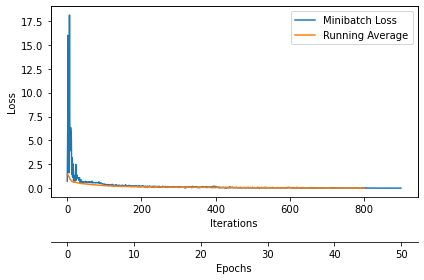

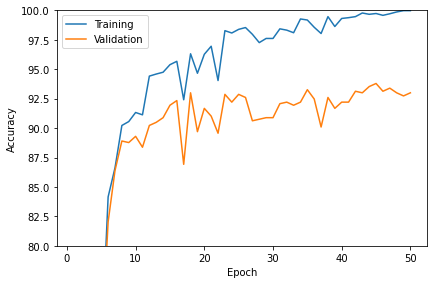

In [8]:
model = ResNet(BasicBlock, layers = [3,4,6,3], num_classes = 2) # ResNet34
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    test_loader=test_loader,
    valid_loader = valid_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=3)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.savefig('ResNet34_training_loss.png')
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.savefig('ResNet34_accuracy.png')
plt.show()

In [9]:
torch.save(model.state_dict(), 'ResNet34_model.pt')
torch.save(optimizer.state_dict(), 'ResNet34_optimizer.pt')
torch.save(scheduler.state_dict(), 'ResNet34_scheduler.pt')